# Data Preparation
- Prepare dataset in order to fit the requirements and assumptions for the SMA trading strategy
#### Takeaway:
- Need to create  SMA (2) variables for trading strategy implementation nad test the combinations for statistical relevance

### 1. Import libraries, functions and download dataset

In [6]:
# Import libraries and functions defined in the separate file
from utils import *
import pandas as pd
import itertools
import multiprocess as mp
from tqdm import *

In [2]:
# Download data
raw_df = get_df()

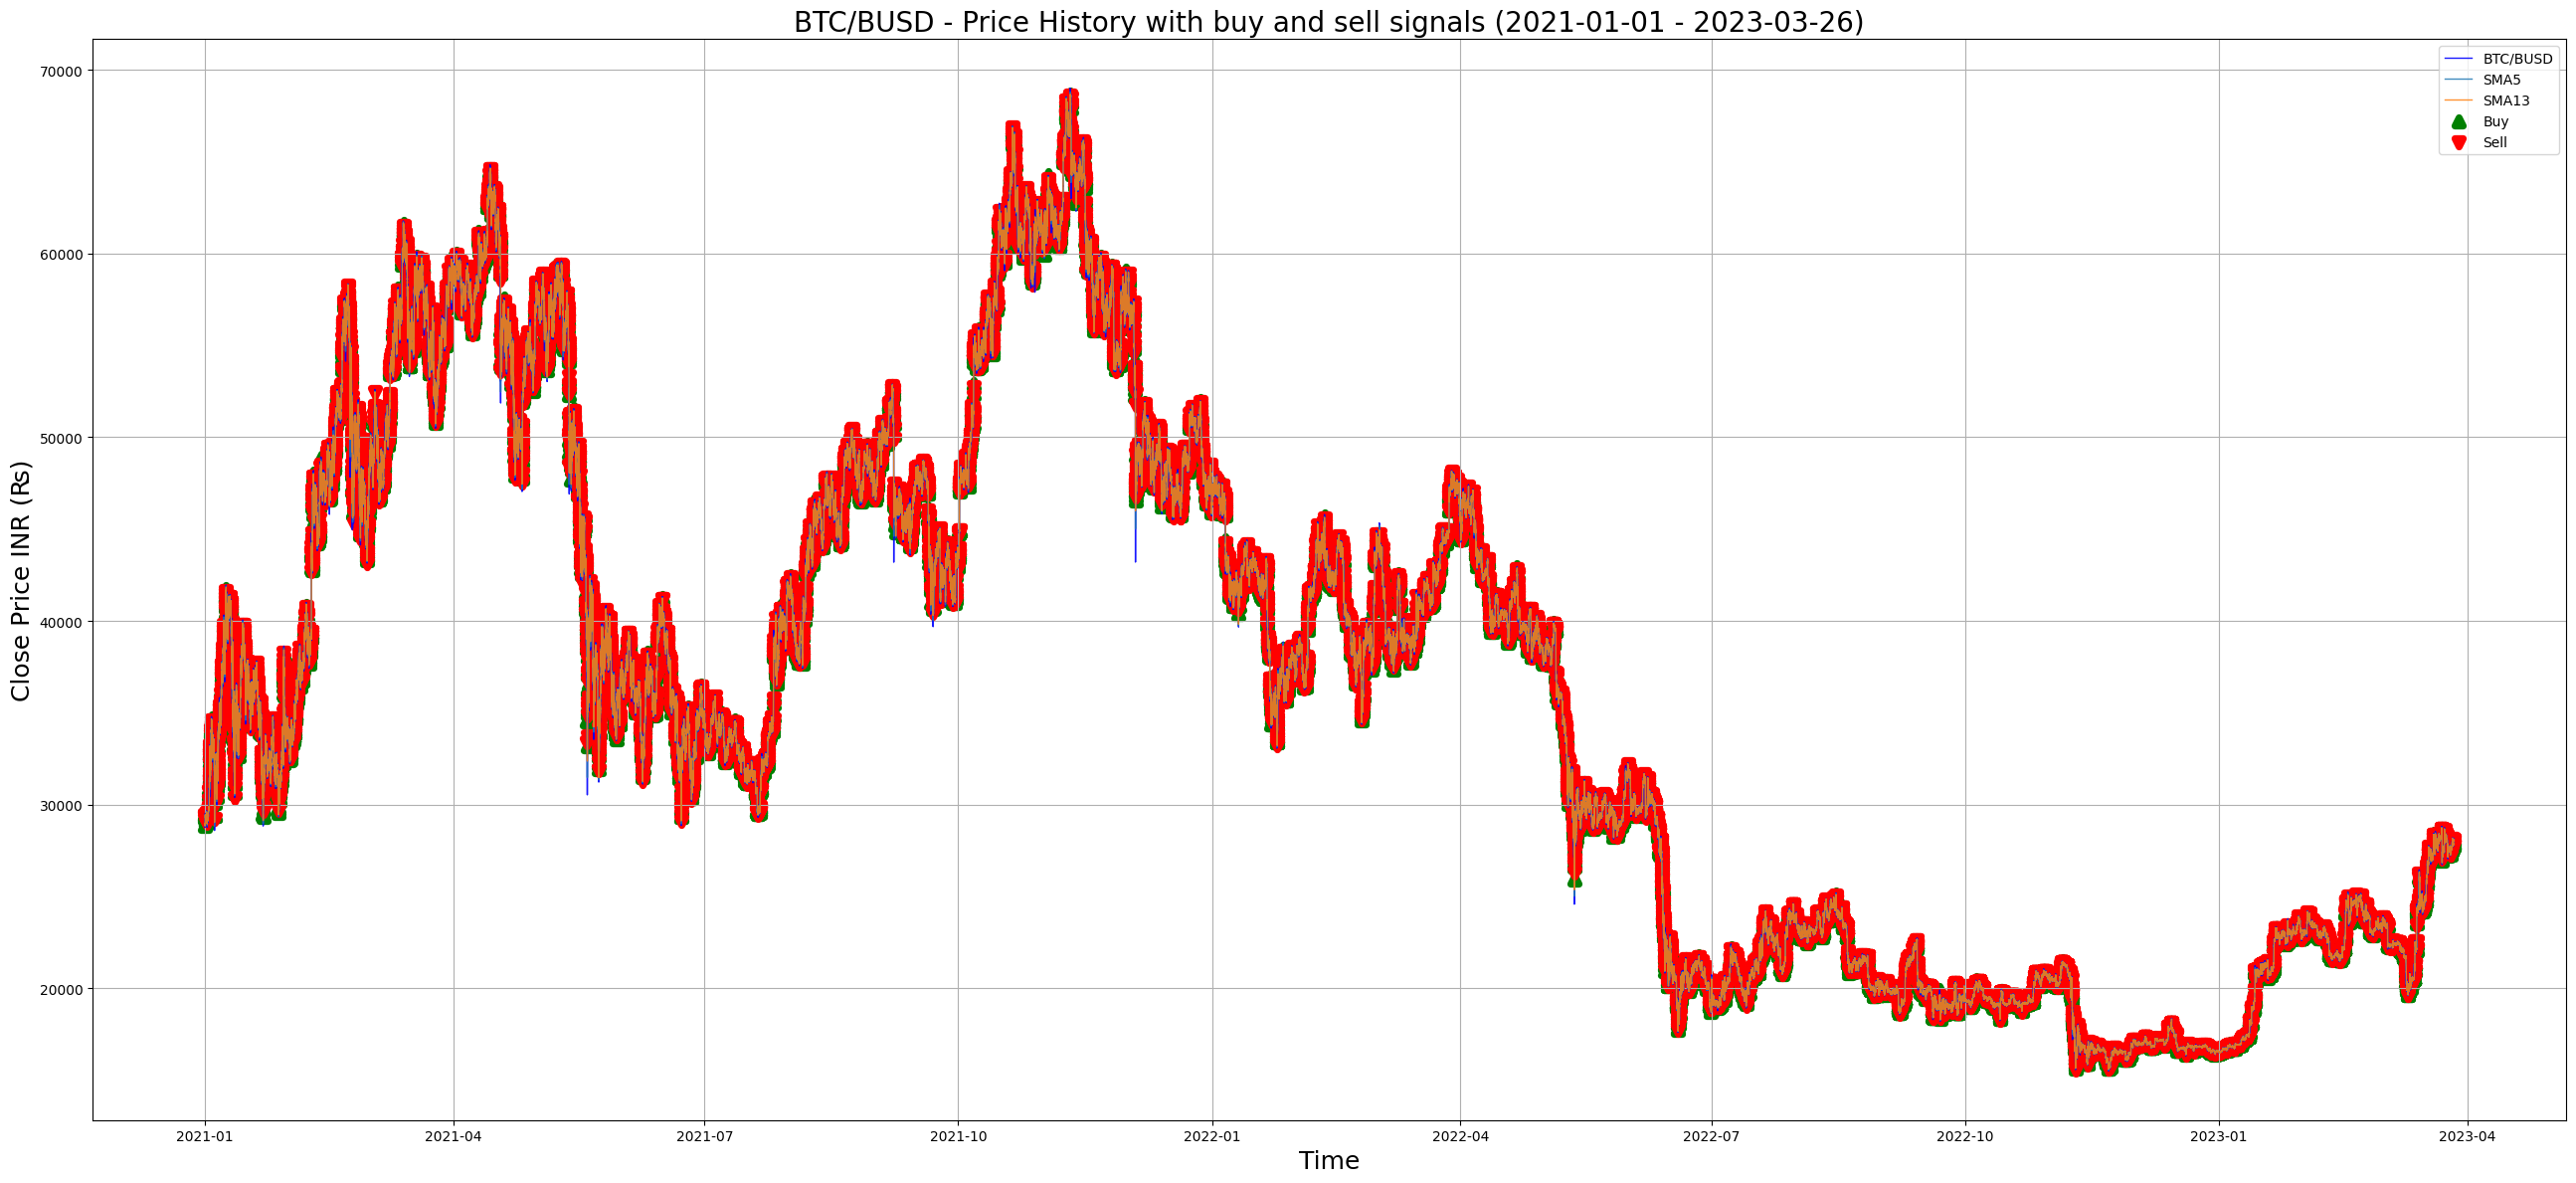

{'average_profit_multiplier': 0.9999609563247097,
 'buy_sell_trade_pair_count': 52769.0,
 'overall_profit_multiplier': 0.19485496544756548}

In [3]:
# Plot SMA strategy and evaluate

# Set parameters
SMA_short = 5
SMA_long = 13
start_date = '2021-01-01'
end_date = '2023-03-26'
# Plot 
plot_SMA(raw_df.copy(), SMA_short, SMA_long, start_date, end_date)
# Evaluate strategy settings
evaluate_signals(SMA_data(raw_df.copy(), SMA_short, SMA_long))

100%|██████████| 3422/3422 [01:55<00:00, 29.53it/s]


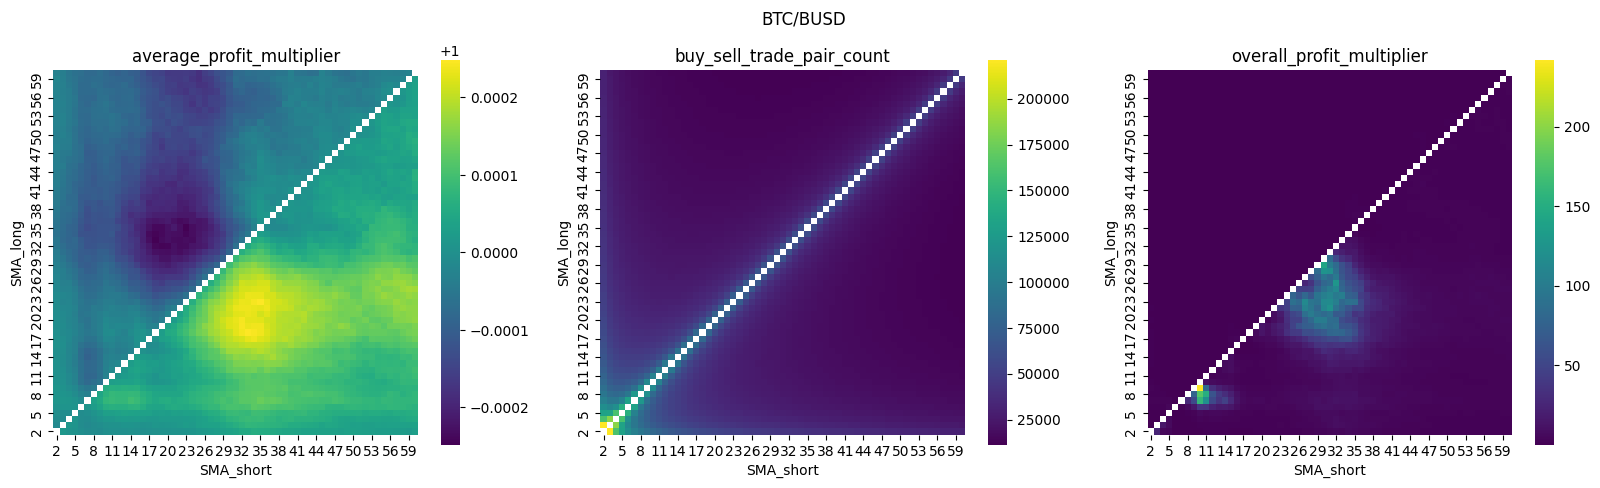

In [5]:
# Create lists with ranges of SMAs values for combinations calculation

# Short SMA list
SMA_short_list = list(range(2,61))
# Long SMA list
SMA_long_list = list(range(2,61))
# Calculate all of the combinations
SMA_combinations = list(itertools.product(SMA_short_list, SMA_long_list))
# Exclude pairs with the same lengths
SMA_combinations = [pair for pair in SMA_combinations if pair[0] != pair[1]]


with mp.Pool(8) as pool:
    results_list = []
    for result in tqdm(pool.imap(evaluate_sma_combination, SMA_combinations), total=len(SMA_combinations)):
        results_list.append(result)
    results = pd.DataFrame(results_list)
    
heatmaps_SMA(results, 'BTC/BUSD')

In [9]:
results.nlargest(10, 'overall_profit_multiplier')

,SMA_short,SMA_long,average_profit_multiplier,buy_sell_trade_pair_count,overall_profit_multiplier
typing.Literal[<no_default>],,,,,
423,10,9,1.000055,109753.0,242.120994
422,10,8,1.000068,83055.0,177.435616
474,11,8,1.000082,68057.0,151.916933
475,11,9,1.000064,78525.0,83.871376
370,9,8,1.000044,115967.5,75.737178
526,12,8,1.000079,59217.0,62.626528
578,13,8,1.000079,53061.0,41.014205
527,12,9,1.000061,64245.0,31.987752
630,14,8,1.000082,48663.0,31.106949
